# Optimizing JupyterHub startup time

This is some analysis of timings for optimizing JupyterHub startup time while avoiding shifting that time too much to single subsequent requests.

Specifically for [jupyterhub#1643](https://github.com/jupyterhub/jupyterhub/pull/1643)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()

Each run is stored in a CSV file, with three measurements:

- startup: the total startup time of JupyterHub
- spawn: the time for init_spawners only (typically dominates startup)
- first_users: the time to complete the first GET /api/users request
- second_users: the time to complete the second GET /api/users request,
  which should be typical of subsequent requests, e.g. by the idle culler

In [2]:
stable = pd.read_csv('0.8.1.csv')

In [3]:
stable.tail()

,users,active,running,startup,spawn,first_users,second_users
28,2000,0.50,1000,28.765178,28.628157,1.907395,0.086458
29,2000,1.00,2000,31.280067,31.087540,1.927571,0.080769
30,5000,0.00,0,131.684187,131.522529,4.856948,0.243989
31,5000,0.10,500,140.643983,140.475580,4.658750,0.183766
32,5000,0.25,1250,142.944982,142.784101,4.559983,0.183655


The `generate-data` script runs `startup-perf` to gather data for each commit in the PR.

In [4]:
import os
jupyterhub_dir = os.path.expanduser('~/dev/jpy/jupyterhub')
BASE_REF = 'dde7b5ea68989b47f4f588a99148fe6cc70f3d29'
BRANCH = 'startup-lite'

from subprocess import check_output
all_refs = [BASE_REF]
all_refs.extend(
    check_output(['git', 'revlist', f'{BASE_REF}..{BRANCH}'],
                 cwd=jupyterhub_dir).decode('ascii').split()[::-1]
)

# ignore some commits that have bugs preventing them from producing valid data
broken = set()
all_refs

['dde7b5ea68989b47f4f588a99148fe6cc70f3d29',
 '6d6041a3c1b10b23c4028b9d2d0206b177d94db6',
 '0315dd5612330a83fdd87fc713e1bb8a098946fd',
 '06fb94b4eab4b008c811c8205df7e9d0391042a2',
 'c8b4cab022391cdf6ec5a6012bfb059f76fe14b6',
 'fb3bc956230e7e30272416c41cfc8da874708db7',
 '0c6aa064ac27fce1da26d49bd530fe2e1c67afe1',
 'd9f5adb1fb13b6faf0a71d34a05627aae7b8a842',
 'd5f0137052a7ab2371102db4c2fcecf029ea7810']

In [5]:
csvs = [ f"{ref[:7]}.csv" for ref in all_refs if ref not in broken]
csvs

['dde7b5e.csv',
 '6d6041a.csv',
 '0315dd5.csv',
 '06fb94b.csv',
 'c8b4cab.csv',
 'fb3bc95.csv',
 '0c6aa06.csv',
 'd9f5adb.csv',
 'd5f0137.csv']

Load the CSV files into data frames

In [6]:
names = []
frames = []

for csv in csvs:
    if os.path.exists(csv):
        names.append(csv[:-4])
        frames.append(pd.read_csv(csv))
        

We can plot our three metrics for a given commit:

/Users/benjaminrk/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


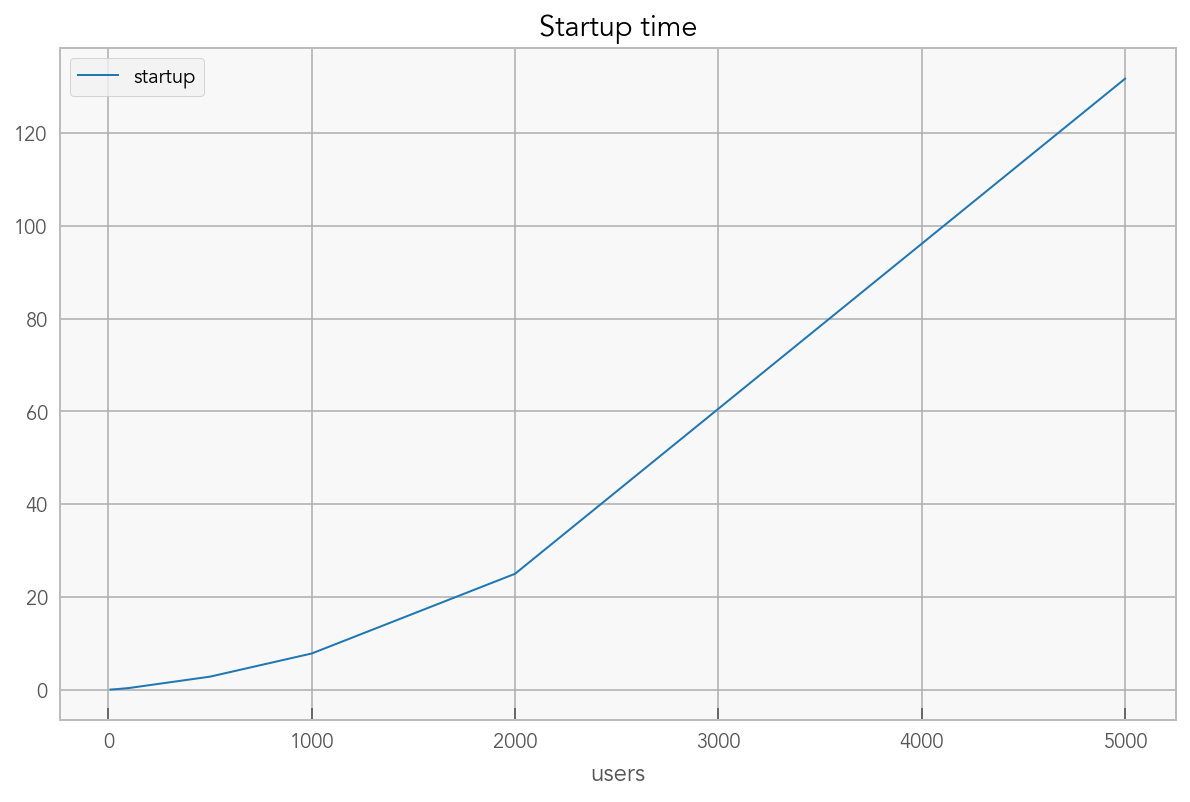

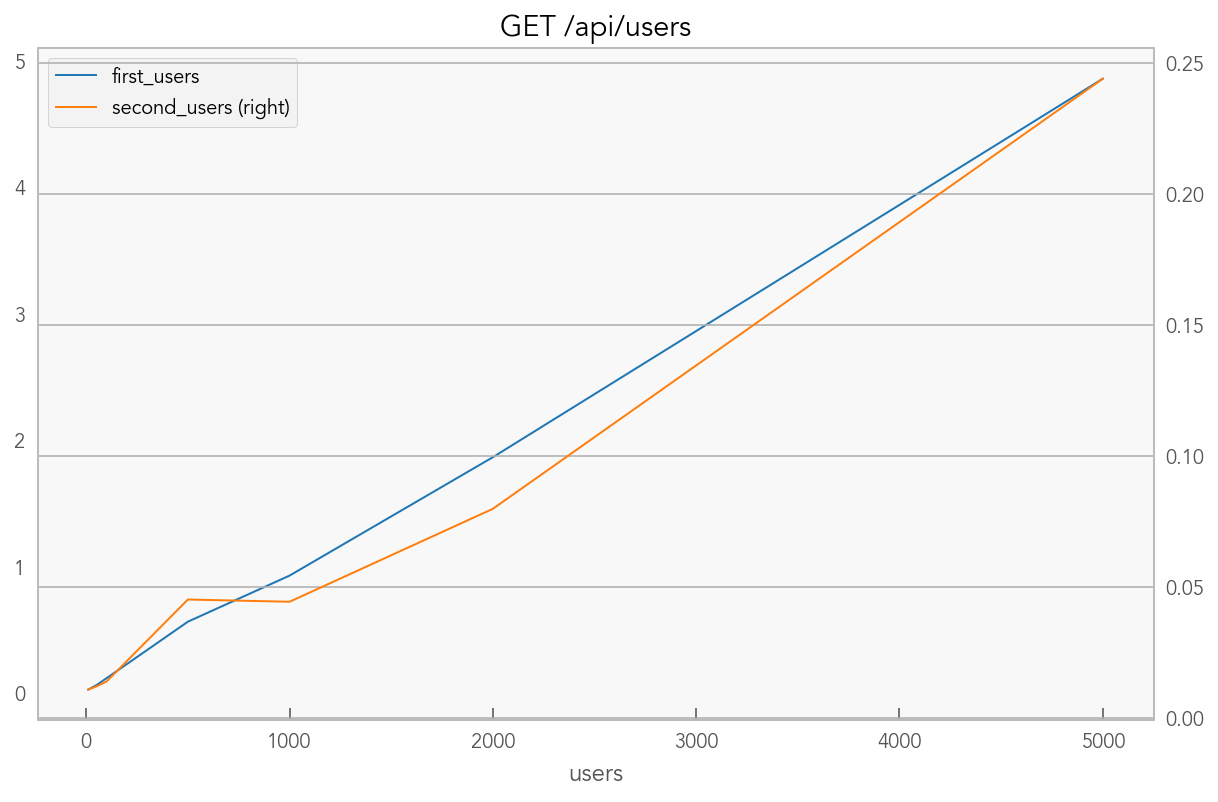

In [7]:
def plot_active(df, active=0):
    df = df[df.active == active]
    df.plot(x='users', y='startup')
    plt.title("Startup time")
    df.plot(x='users', y=['first_users', 'second_users'], secondary_y=['second_users'])
    plt.title("GET /api/users")

plot_active(stable)

Plot startup time vs active users. This is the biggest thing we are changing

In [8]:
def plot_vs_running(df):
    user_counts = df.users.unique()
    for u in user_counts:
        data = df[df.users==u]
        plt.plot(data.running, data.startup, label=f'{u} users')
    plt.legend(loc=0)
    plt.title("Startup time")
    plt.xlabel("active users")
    plt.ylabel("Seconds")


In 0.8.1 startup time is a ~fixed (high) cost based on the number of users, insensitive to whether they are running or not.

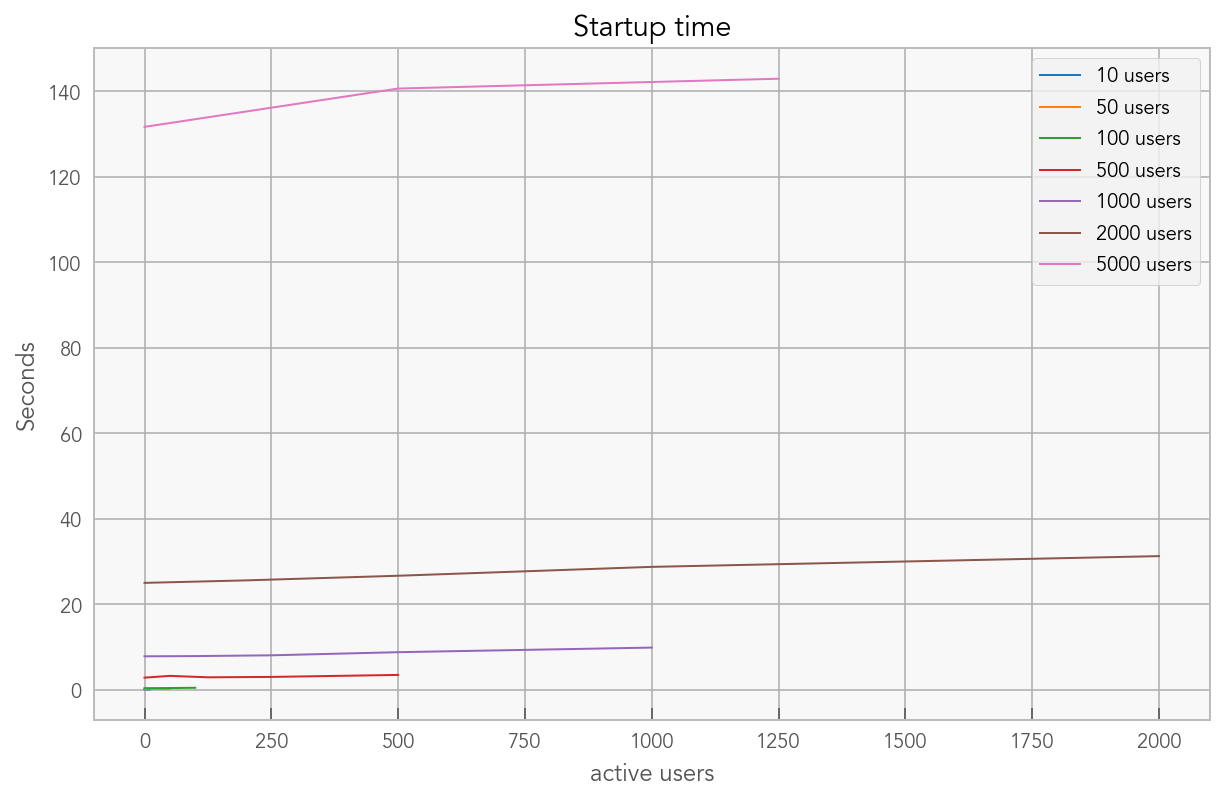

In [9]:
plot_vs_running(stable)

With the latest update, startup time is now much faster, and extra quick when few users were running at startup time (typically true).

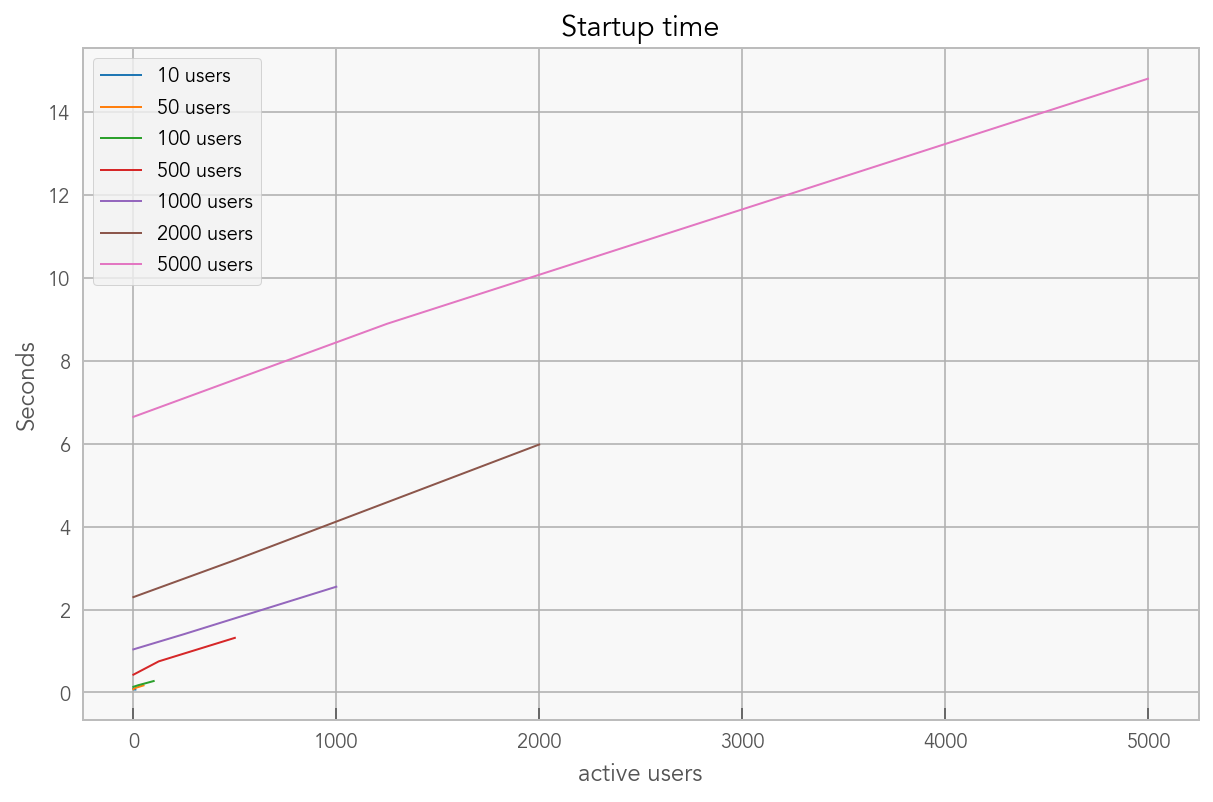

In [10]:
plot_vs_running(frames[-1])

Now we can try to compare our three metrics (startup time, first GET /api/users, second GET /api/users) across the commits.

In [11]:
import bokeh.plotting as bp
import bokeh.models as bm
bp.output_notebook()

Loading BokehJS ...

In [12]:
from itertools import cycle

from bokeh.layouts import column
from bokeh.palettes import Category10

def plot_compare(frames, labels, y, active=0):
    colors = Category10[len(frames)]

    if not isinstance(y, list):
        y = [y]
    plots = []
    for col in y:
        p = bp.figure()
        p.add_layout(bm.Title(
            text=f"{col} time with {int(active * 100)}% active users",
            align="center"), "above")
        p.xaxis.axis_label = 'users'
        p.yaxis.axis_label = 'seconds'

        p.add_tools(bm.HoverTool(
            tooltips=[
                ('commit', '@name'),
                ('time', '$y s'),
                ('users', '$x{0}'),
            ],
        ))
        for df, label, color in zip(frames, labels, colors):
            data = df[df.active==active]
            source = bp.ColumnDataSource(
                data=dict(
                    x=data.users,
                    y=data[col],
                    name=[label] * len(data),
                )
            )
            last_value = data[col].max()
            legend = f"{label} ({last_value:.1f}s)"
            line = p.line('x', 'y', color=color, legend=legend, source=source)
#             p.add_tools(HoverTool(
#                 renderers=[line],
#                 tooltips=[('commit', label)]
#             ))

        p.legend.location = "top_left"
        p.legend.click_policy="hide"
        plots.append(p)
#         plt.ylabel("seconds")
#         plt.title(f)
    p = column(*plots)
    bp.show(p)
    return p

p = plot_compare(frames, names, ['startup', 'first_users', 'second_users'])

The above is the best case scenario for startup optimizations: No active users. Below, we can do the same plots for the worst case: 100% active users.

In [13]:
plot_compare(frames, names, ['startup', 'first_users', 'second_users'], active=1)

Column(id='8f810c19-80c7-4e77-925b-8ebae44be1a5', ...)

It's hard to inspect those lines too closely.
If we just look at 0% and 100% activity for 5k users, we can get fairly 

In [14]:
def bar_compare(frames, names, col, users=5000):
    data = []
    for name, df in zip(names, frames):
        df = df[df.users == users]
        data.append([name, df[df.active==0][col].max(), df[df.active==1][col].max()])
    df = pd.DataFrame(data, columns=['commit', '0% active', '100% active'])
    ax = plt.gca()
    df.plot.bar(ax=ax, x='commit')
    ax.set_yscale('log')
    ax.set_title(f"{col} time for {users} users")
    ax.set_ylabel("seconds")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(min(ymin, 1e-1), max(ymax, 1e1))
    

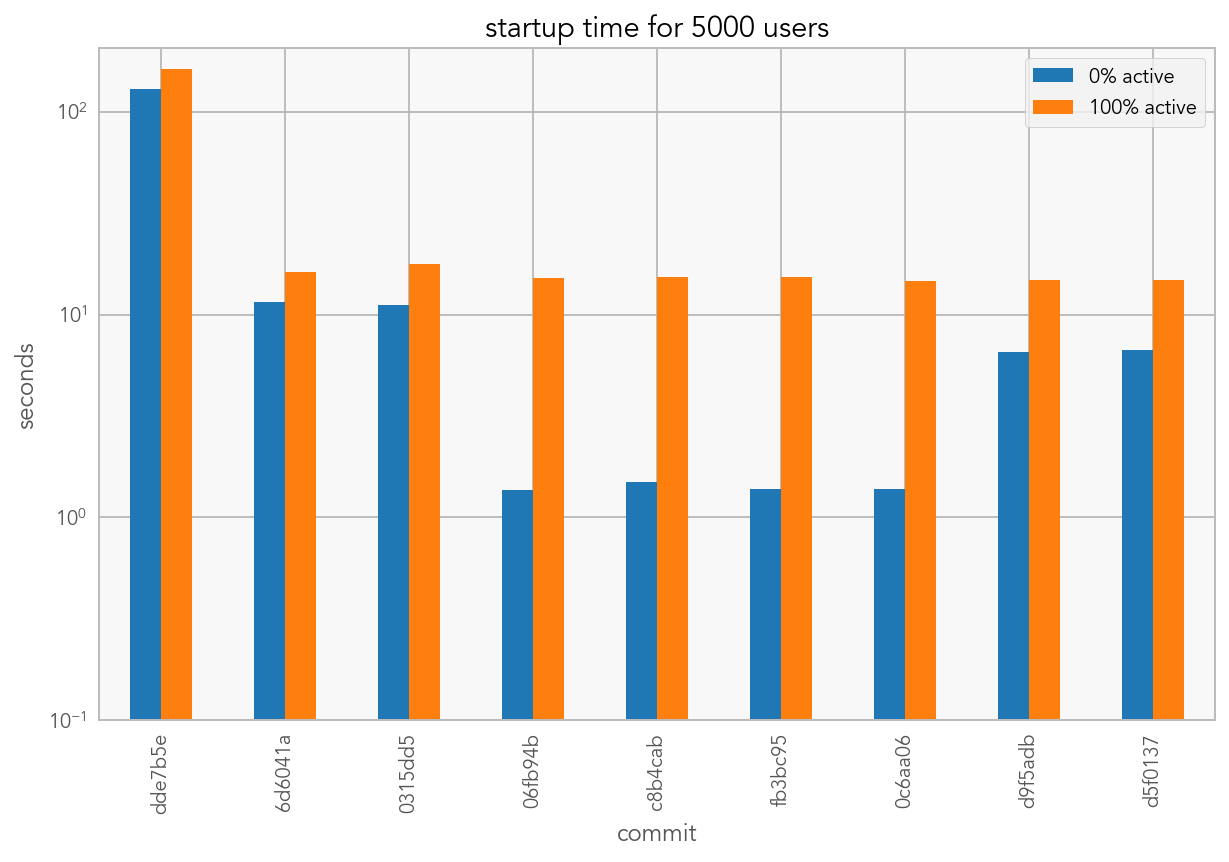

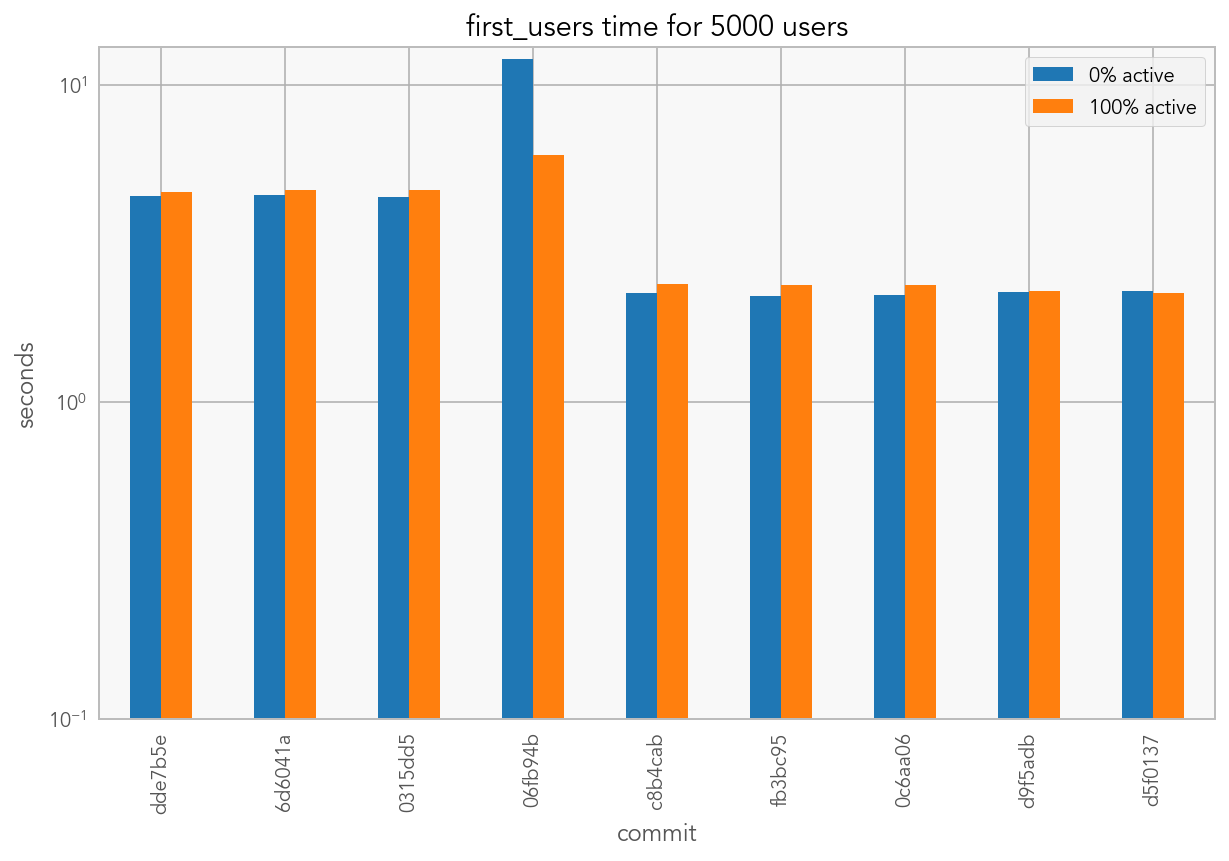

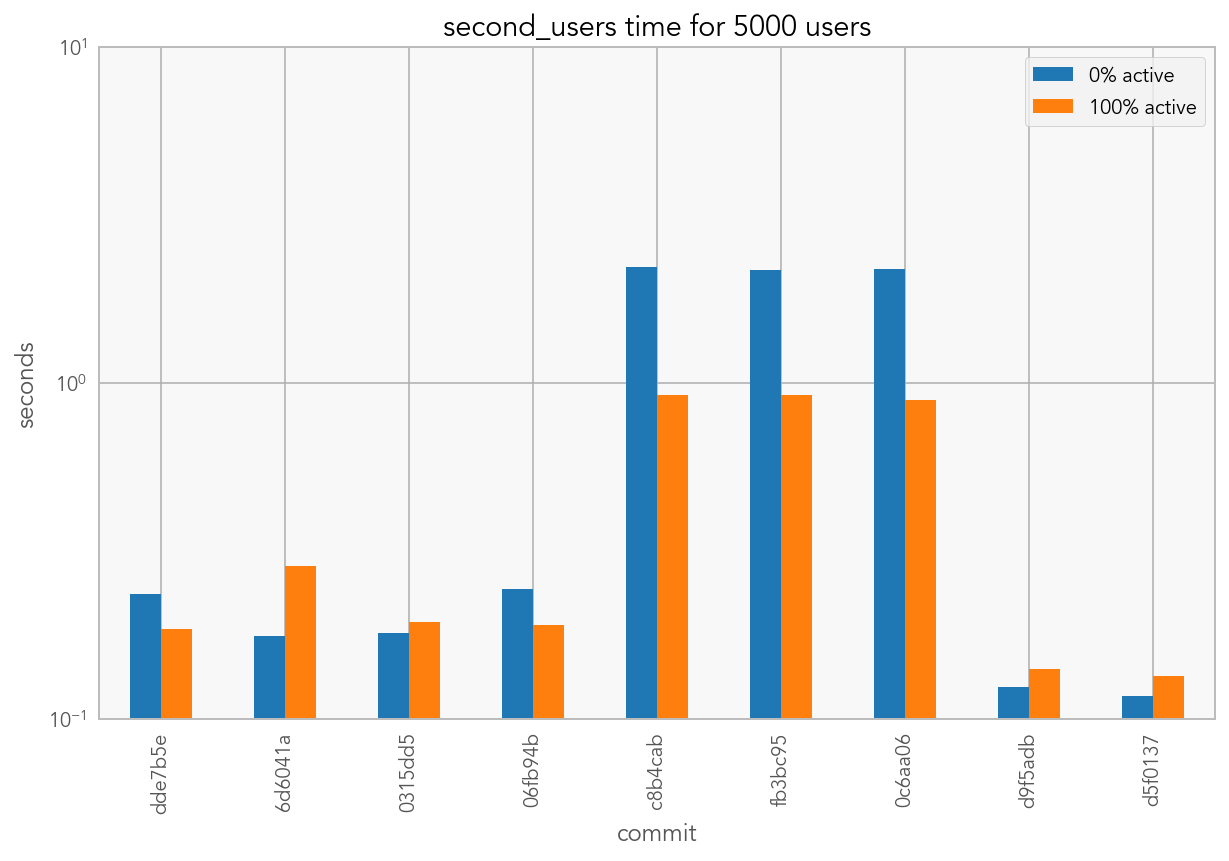

In [15]:
bar_compare(frames, names, 'startup')
plt.figure()
bar_compare(frames, names, 'first_users')
plt.figure()
bar_compare(frames, names, 'second_users')

Summary of results:
    
- Parallelizing spawn checking in `6d6041a` saved quite a bit, despite the test Spawners not doing anything asynchronous.
- Delaying instantiation of Spawners was the biggest win in startup when everyone is idle. Delaying instantiation of Users is a second big win in `06fb94b`.
- However, delaying the instantiation of users only results in doing the same instantiation on the first all-users operation, delaying a big blocking operation to the first GET /api/users, seen in the second graph.
- Attempting to fix this delay in `c8b4cab` by allowing GET /api/users to operate without instantiating User wrappers did indeed greatly improve the first GET /api/users request, but at the expense of every subsequent request costing the same as the first, rather than using cached values.

In the end, a compromise is reached:

1. rather than optimizing idle-user startup time at the expense of runtime delays, only Spawner instantiation is optimized. This 
2. startup time is greatly improved (~8s for 5k inactive users, from ~3 minutes), but not all the way to our best of ~1s, which could only be achieved at the expense of more valuable runtime request performance.
3. first request to all users is improved by further avoiding instantiation of Spawner objects that are not running
4. subsequent requests for all users are improved by maintaining an in-memory cache of all users (status quo, but sacrificed in some intermediate optimizations to prioritize startup)
